# Predicting US Airline Passenger Satisfaction Based on Various Features

In [38]:
import pandas as pd
import pandera as pa

## Summary
This project aims to create a robust predictive model of US airline customer satisfaction. Understanding customer satisfaction is very important for airlines as it provides directions to improve the service and equipment. The dataset contains a variety of flight information and a target variable indicating if the customer was satisfied or not. After proper processing and predictive modeling with algorithms like Logistic Regression and Decision Trees, we produced a reliable model that can predict customer satisfaction with 94% accuracy (given the necessary flight information). The results are quite impressive, as they provide very high performance indicating ability to distinguish between satisfied and unsatisfied customers.

## Introduction

In the highly competitive field of air transport management, passenger satisfaction plays a critical role in making customer loyalty, providing operational insights, enhancing financial performance, and ensuring compliance with regulations and rankings (Sadegh Eshaghi et al, 2024). While there are numerous studies held on factors influencing customer satisfaction like service quality (Namukasa, 2023), it is very important to be able to predict the customer satisfaction with high accuracy for understanding how to improve and make better decisions. In this study, we aim to create a reliable predictive model that will predict US airline passenger satisfaction with high performance.

## Methods

### Data
The dataset contains a variety of features from passengers’ flight experiences, including:

- **Demographic data** (e.g., age, gender)
- **Flight details** (e.g., flight distance, time of day)
- **Service-related features** (e.g., quality of meal, seat comfort, check-in process)

The data was pre-processed by:

- Removing unnecessary columns
- Scaling numerical features
  
This data was sourced from Kaggle and can be found from [here](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?select=train.csv). We use Pandas library for storing and manipulating the dataset (McKinney, 2010).

### Model
We used the following three models to predict customer satisfaction from the given attributes:
- Dummy Classifier (serving as a baseline)
- Logistic Regression
- Decision Trees

We then use K-Fold cross-validation for finding the best performing model.

### Evaluation Metric
We used different evaluation metrics to have proper evaluation of the model performance. The metrics include accuracy, weighted recall, weighted precision and F1-Score.


## EDA
For an exploratory data analysis (EDA) on the Airline Passenger Satisfaction dataset, the goal is to better understand the structure of the dataset, identify potential issues (such as missing values, outliers, etc.), and uncover initial insights about the factors that might influence passenger satisfaction.


### Understanding the Dataset
- First, we need to load the dataset and check the basic structure.
- We will check the number of rows and columns, data types of each feature, and get a basic sense of how the data is organized.

In [2]:
# Load the dataset
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

In [3]:
print("The shape of the training data is:", train_data.shape)
print("The shape of the test data is:", test_data.shape)

The shape of the training data is: (103904, 25)
The shape of the test data is: (25976, 25)


In [4]:
# Basic overview of the train dataset
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [48]:
# validate data
schema = pa.DataFrameSchema(
    {
        "Gender": pa.Column(str, pa.Check.isin(["Male", "Female"]), nullable=False),
        "Customer Type": pa.Column(str, pa.Check.isin(["Loyal Customer", "Disloyal Customer"]), nullable=False),
        "Age": pa.Column(int, pa.Check.between(0, 90), nullable=False),
        "Type of Travel": pa.Column(str, pa.Check.isin(["Business travel", "Personal Travel"]), nullable=False),
        "Class": pa.Column(str, pa.Check.isin(["Eco", "Eco Plus", "Business"]), nullable=False),
        "Flight Distance": pa.Column(float, pa.Check.greater_than(0), nullable=False),
        "Inflight wifi service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Departure/Arrival time convenient": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Ease of Online booking": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Gate location": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Food and drink": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Online boarding": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Seat comfort": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Inflight entertainment": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "On-board service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Leg room service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Baggage handling": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Checkin service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Inflight service": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Cleanliness": pa.Column(int, pa.Check.between(0, 5), nullable=True),
        "Departure Delay in Minutes": pa.Column(float, pa.Check.greater_than_or_equal_to(0), nullable=True),
        "Arrival Delay in Minutes": pa.Column(float, pa.Check.greater_than_or_equal_to(0), nullable=True),
        "satisfaction": pa.Column(str, pa.Check.isin(["neutral or dissatisfied", "satisfied"]), nullable=False),
    },
    checks=[
        pa.Check(lambda df: ~df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error="Empty rows found.")
    ])

In [49]:
train_data["Customer Type"] = train_data["Customer Type"].str.title()
train_data["Departure Delay in Minutes"] = train_data["Departure Delay in Minutes"].astype(float)
train_data["Flight Distance"] = train_data["Flight Distance"].astype(float)

try:
    schema.validate(train_data, lazy=True)
    print("Data validation passed.")
except pa.errors.SchemaErrors as e:
    print(e.failure_cases)

Data validation passed.


### Missing Values and Data Quality
- Identify if there are any missing or null values in the dataset.
- Check for duplicates or any irrelevant columns that do not add value to the analysis.

In [5]:
# Check for missing values
print(train_data.isnull().sum())

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [6]:
# Check for duplicates
print(train_data.duplicated().sum())

0


There are no duplicate values. The missing values are only in one column named "Arrival Delay in Minutes", which is a numeric variable.

### Data Types and Features
- Analyze the data types (e.g., categorical, numerical, datetime) of each column.
- For categorical features, check the number of unique values.
- For numerical features, check their ranges, distributions, and potential outliers.

In [7]:
# Check data types and unique values
train_data.dtypes

Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

There are 4 features having text values and the rest is already numeric (regardless if it is ordinal or continuous).

In [8]:
train_data.nunique()

Unnamed: 0                           103904
id                                   103904
Gender                                    2
Customer Type                             2
Age                                      75
Type of Travel                            2
Class                                     3
Flight Distance                        3802
Inflight wifi service                     6
Departure/Arrival time convenient         6
Ease of Online booking                    6
Gate location                             6
Food and drink                            6
Online boarding                           6
Seat comfort                              6
Inflight entertainment                    6
On-board service                          6
Leg room service                          6
Baggage handling                          5
Checkin service                           6
Inflight service                          6
Cleanliness                               6
Departure Delay in Minutes      

The number of unique values show that there are two unique identifier columns which should be removed.

### Distribution of Numerical Variables
Plot histograms or boxplots for all numerical features to check their distribution and identify any outliers.

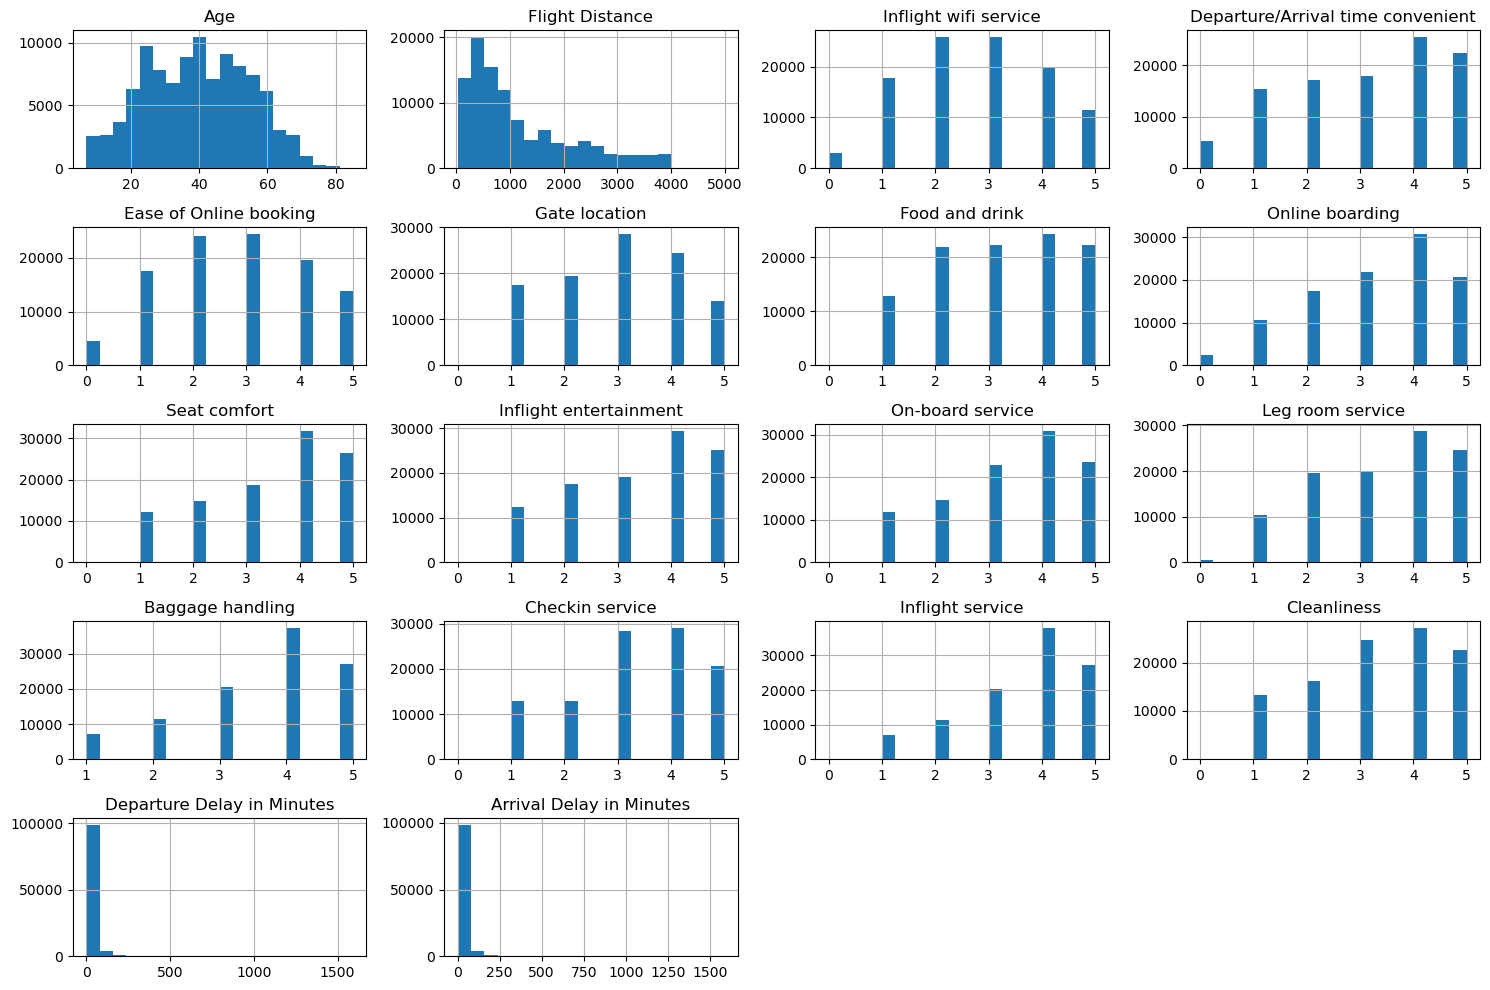

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

train_data = train_data.drop(['Unnamed: 0', 'id'], axis=1)

# Histograms for numerical features
train_data.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()


The histogram (and barplot) of the values show that the unique categories for categorical variables have significant number of observations per group which is good. The numeric variables except age are mostly right skewed. So, most of them are not close to normal distribution.

### Correlation Between Features
- Check how numerical features correlate with each other, and see if there are any strong correlations. This can be done using a correlation matrix and visualized with a heatmap.

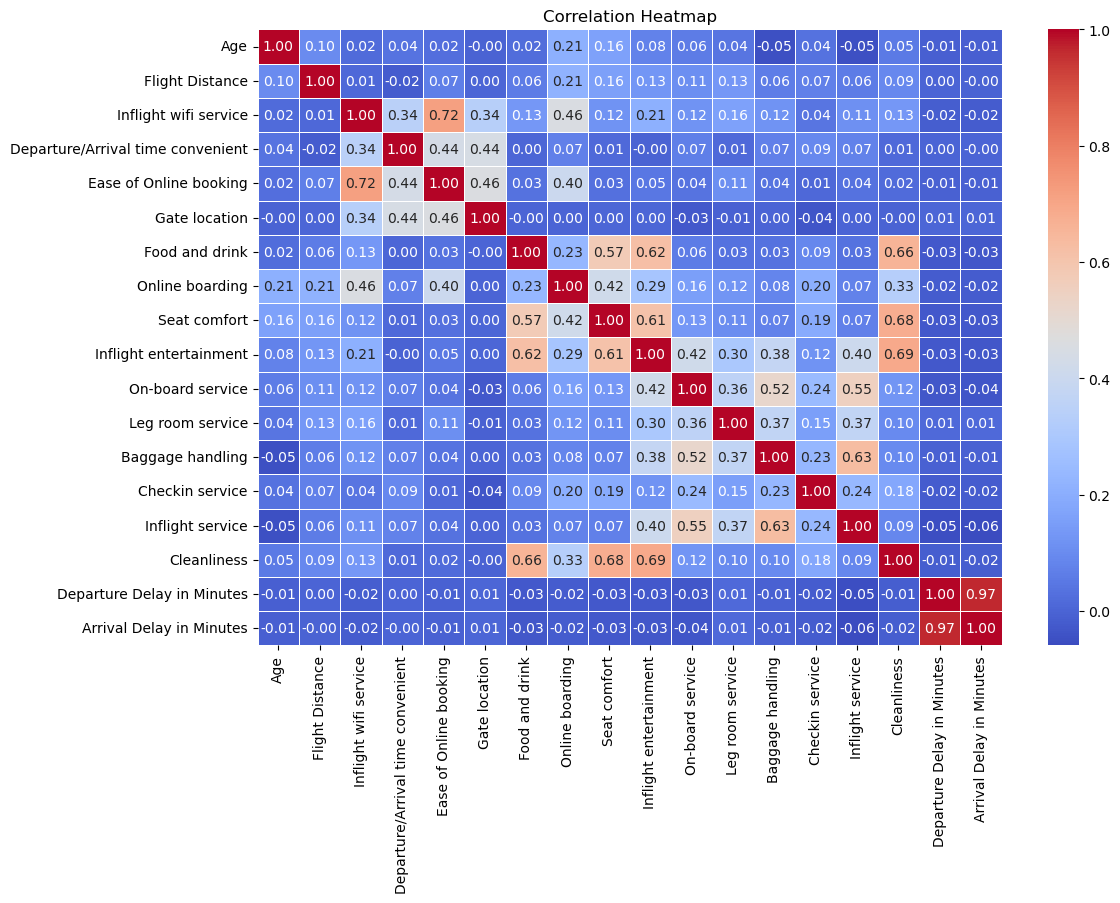

In [10]:
# Correlation matrix
numeric_data = train_data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


Some features have high correlation suggesting multicollinearity. Departure Delay in Minutes vs. Arrival Delay in Minutes are very high correlated features. They both contain the same information, so one of them can be deleted.

### Distribution of Target Variable


Understanding the distribution of the target variable is crucial for understanding the problem type and guiding our approach.  

* Examine the data type of the target variable
* Visualize the target variable's distribution 

We start off by viewing the first few columns of the target variable

In [11]:
train_data['satisfaction'].head()

0    neutral or dissatisfied
1    neutral or dissatisfied
2                  satisfied
3    neutral or dissatisfied
4                  satisfied
Name: satisfaction, dtype: object

It seems to contain text data(characters) we can confirm that by viewing the data type, and the unique groups, if any, in the data.

In [12]:
print(f"The data type for the target column is {train_data['satisfaction'].dtype}")

The data type for the target column is object


In [13]:
print(f"The target variable 'satisfaction' consists of {train_data['satisfaction'].nunique()} unique categories, {' and '.join(train_data['satisfaction'].unique())}")

The target variable 'satisfaction' consists of 2 unique categories, neutral or dissatisfied and satisfied


It does contain text data but in the form of a category. There are 2 distinct categories for our text data.

To get a better idea of the target variable we plot the distribution of the class below.

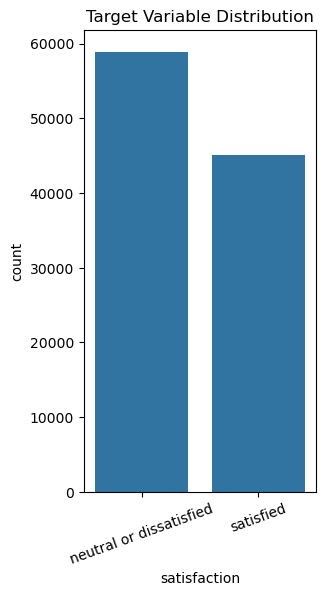

In [14]:
plt.figure(figsize = (3,6))
sns.countplot(data=train_data, x='satisfaction')
plt.title("Target Variable Distribution")
plt.xticks(rotation = 20)
plt.show()

In [15]:
train_data['satisfaction'].value_counts(normalize=True)

neutral or dissatisfied    0.566667
satisfied                  0.433333
Name: satisfaction, dtype: float64

There are slightly more `neutral or dissatisfied` observations than there are `satisfied` observations.

## Preprocessing Steps for the Airline Passenger Satisfaction Dataset

### 1. Removing the "Arrival Delay In Minutes" feature
The feature has both missing values and very high correlation with "Departure Delay In Minutes" feature. 

### 2. Encoding Categorical Variables
Categorical columns like Gender, Type of Travel, Class, Satisfaction, and others will need to be encoded:

- **Satisfaction** will be encoded as a binary variable (`0` for "Dissatisfied", `1` for "Satisfied").
- Other categorical variables will be encoded using **one-hot encoding**, where applicable.

### 3. Scaling Numerical Features
We need to **standardize** or **scale** numerical features like Age, Flight Distance, Seat Comfort, Inflight Wifi Service, etc., so that they all have similar scales. This will help avoid dominance of variables with larger ranges.


In [16]:
X_train = train_data.drop(['satisfaction', 'Arrival Delay in Minutes'], axis=1)  
y_train = train_data['satisfaction']

In [17]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 
                    'Inflight wifi service', 'Departure/Arrival time convenient', 
                    'Ease of Online booking', 'Gate location', 'Food and drink', 
                    'Online boarding', 'Seat comfort', 'Inflight entertainment', 
                    'On-board service', 'Leg room service', 'Baggage handling', 
                    'Checkin service', 'Inflight service', 'Cleanliness']


numerical_cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']


preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    (StandardScaler(), numerical_cols)
)

preprocessor

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Customer Type', 'Type of Travel',
                                  'Class', 'Inflight wifi service',
                                  'Departure/Arrival time convenient',
                                  'Ease of Online booking', 'Gate location',
                                  'Food and drink', 'Online boarding',
                                  'Seat comfort', 'Inflight entertainment',
                                  'On-board service', 'Leg room service',
                                  'Baggage handling', 'Checkin service',
                                  'Inflight service', 'Cleanliness']),
                                ('standardscaler', StandardScaler(),
                                 ['Age', 'Flight Distance',
                                  'Departure Delay in Minutes'])])

## Modelling

Firstly, we define the problem type by reviewing our target variable.

In [18]:
print(f"The target variable 'satisfaction' consists of {train_data['satisfaction'].nunique()} unique categories, {' and '.join(train_data['satisfaction'].unique())}")

The target variable 'satisfaction' consists of 2 unique categories, neutral or dissatisfied and satisfied


The target variable `satisfaction`, representing airline satisfaction, is a categorical variable(specifically, a binary variable). Therefore, we can frame this as a classifcation problem.

Defining the problem type aids in the selection of an appropriate model type.
As a baseline, the Dummy Classification model will be used, it predicts the majority class. For comparison, more sophisticated models will be implemented such as Support Vector Classification (SVC), Logistic Regression, and k-Nearest Neighbors (k-NN).

In [19]:
from sklearn.pipeline import make_pipeline

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

We use scikit-learn library for training machine learning models (Pedregosa, 2021)

### Base Model

Our baseline model is the `DummyClassifier`, which predicts the majority class. This serves as a reference point for evaluating the performance of other models. Any model we implement should demonstrate performance that surpasses this baseline to be considered effective.

In [21]:
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=123)
dummy_results = pd.DataFrame(cross_validate(dummy_clf, X_train, y_train, return_train_score=True))

In [22]:
dummy_results

,fit_time,score_time,test_score,train_score
0,0.060879,0.040871,0.566671,0.566666
1,0.053035,0.044492,0.566671,0.566666
2,0.054847,0.040505,0.566671,0.566666
3,0.053513,0.041939,0.566671,0.566666
4,0.054033,0.043458,0.566651,0.566671


The base model has a validation score of approximately 56% accuracy(accuracy is the percentage of correct predictions and the default classification metric) which corresponds to the percentage of the majority class.

### Comparison Model(s)

With the comparison models we aim to outperform the base models. Let's start with `Logistic Regression`😺

In [23]:
log_clf = make_pipeline(preprocessor, LogisticRegression(random_state=123))
log_results = pd.DataFrame(cross_validate(
    log_clf, 
    X_train, 
    y_train, 
    return_train_score=True
)).rename(columns={'test_score': 'validation_score'})

/Users/shengjiayu/miniforge3/envs/dsci522-airline-pred/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/shengjiayu/miniforge3/envs/dsci522-airline-pred/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

In [24]:
log_results

,fit_time,score_time,validation_score,train_score
0,0.898831,0.072371,0.932390,0.933905
1,0.896059,0.077870,0.933497,0.933917
2,0.867236,0.074605,0.931091,0.934687
3,0.906096,0.077684,0.934989,0.933520
4,0.945364,0.088318,0.934408,0.933738


The Logistic Regression Model greatly outperforms the base model. It generates train and validation with approximately 93% accuracy. This is a significant improvement from the 53% accuracy. 
However, accuracy is not always the best metric in ML.

Below we also consider other models and report **different scoring metrics** for the models.

In [25]:
from sklearn.metrics import make_scorer, f1_score

In [26]:
models = {
    "dummy": DummyClassifier(random_state=123), 
    "Logistic Regression": LogisticRegression(random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
}


scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': make_scorer(f1_score, average='weighted')
}



In [27]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    pipe = make_pipeline(preprocessor, model)
    scores = cross_validate(pipe, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [28]:
results_df = {}

for name, estimator in models.items():
    scores = mean_std_cross_val_scores(estimator,
                                       X_train, y_train, 
                                       return_train_score=True,
                                       scoring=scoring)
    results_df[name] =  scores
    
results_df = pd.DataFrame(results_df).T
results_df.rename(columns={
    'test_accuracy': 'validation_accuracy',
    'test_precision': 'validation_precision',
    'test_recall': 'validation_recall',
    'test_f1': 'validation_f1'
}, inplace=True)


/Users/shengjiayu/miniforge3/envs/dsci522-airline-pred/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shengjiayu/miniforge3/envs/dsci522-airline-pred/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shengjiayu/miniforge3/envs/dsci522-airline-pred/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [29]:
results_df

,fit_time,score_time,validation_accuracy,train_accuracy,validation_precision,train_precision,validation_recall,train_recall,validation_f1,train_f1
dummy,0.253 (+/- 0.006),0.547 (+/- 0.065),0.567 (+/- 0.000),0.567 (+/- 0.000),0.321 (+/- 0.000),0.321 (+/- 0.000),0.567 (+/- 0.000),0.567 (+/- 0.000),0.410 (+/- 0.000),0.410 (+/- 0.000)
Logistic Regression,0.978 (+/- 0.148),0.559 (+/- 0.047),0.933 (+/- 0.002),0.934 (+/- 0.000),0.933 (+/- 0.002),0.934 (+/- 0.000),0.933 (+/- 0.002),0.934 (+/- 0.000),0.933 (+/- 0.002),0.934 (+/- 0.000)
Decision Tree,2.421 (+/- 0.208),0.572 (+/- 0.059),0.947 (+/- 0.001),1.000 (+/- 0.000),0.947 (+/- 0.001),1.000 (+/- 0.000),0.947 (+/- 0.001),1.000 (+/- 0.000),0.947 (+/- 0.001),1.000 (+/- 0.000)


Based on the findings, we determined that **Logistic Regression** is the **optimal model** to utilize since it provides balanced performance across recall and F1-score, both of which are consistently high (0.934) on the validation set. Compared to Decision Tree, which achieves slightly higher scores (0.947) but overfits with perfect training metrics, Logistic Regression demonstrates great generalization by maintaining almost identical performance on both training and validation datasets. Furthermore, Logistic Regression avoids the complexity and overfitting difficulties associated with Decision Trees while remaining computationally efficient and requiring significantly less training time.

# Reporting performance

🔔 Time to evaluate our model on unseen data！

In [30]:
# Prepare the test set
X_test = test_data.drop(columns=['satisfaction', 'Arrival Delay in Minutes'])
y_test = test_data['satisfaction']
y_test = y_test.values.ravel()

# Define the Logistic Regression pipeline
final_model = make_pipeline(preprocessor, LogisticRegression(random_state=123))

# Train the model on the training data
final_model.fit(X_train, y_train.values.ravel())  

# Predict on the test set
y_test_pred = final_model.predict(X_test)

/Users/shengjiayu/miniforge3/envs/dsci522-airline-pred/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Classification Report
We can see that logistic regression worked well on the test set, with all critical metrics (precision, recall, and F1-score) averaging around 93%, indicating a solid balance of false positives and negatives.The Neutral class had the highest recall (95%), reflecting the model's sensitivity in detecting this class, whereas the Satisfied class had a little lower recall (91%), but overall performance remained consistent. The consistency of macro-average and weighted-average scores demonstrates the model's ability to efficiently handle slightly skewed class distributions, demonstrating its stability, generalization capabilities, and dependability as an efficient classification model.

In [31]:
from sklearn.metrics import accuracy_score, classification_report

print("Logistic Regression Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Logistic Regression Test Accuracy: 0.932784108407761

Classification Report:
                          precision    recall  f1-score   support

neutral or dissatisfied       0.93      0.95      0.94     14573
              satisfied       0.93      0.91      0.92     11403

               accuracy                           0.93     25976
              macro avg       0.93      0.93      0.93     25976
           weighted avg       0.93      0.93      0.93     25976



### Confusion Matrix 
The matrix below shows that the model performs well overall, correctly predicting 13,806 "neutral or dissatisfied" and 10,004 "satisfied" samples. There were 992 false negatives where "satisfied" samples were misclassified as "neutral or dissatisfied," and 767 false positives where "neutral or dissatisfied" samples were misclassified as "satisfied." This implies that the model has a higher recall for "Neutral or Dissatisfied" (94.8%) than for "Satisfied" (87.7%), indicating a little bias toward the former. While the model is effective, raising the recall for "Satisfied" by adjusting the decision threshold or rebalancing the data may enhance its performance, particularly if removing missing "Satisfied" cases is critical to the application.


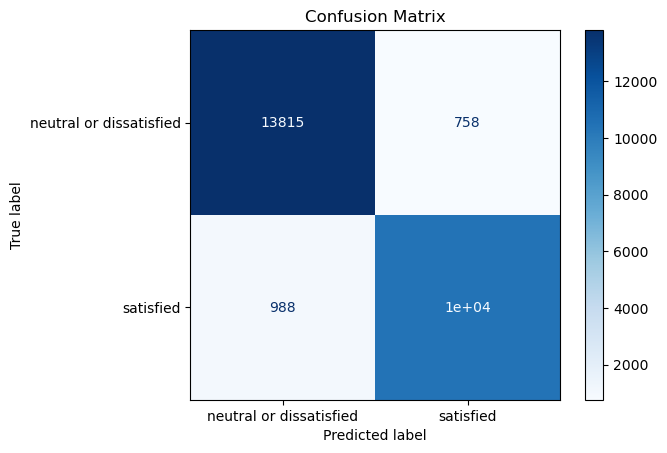

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Precision-Recall
The Precision-Recall curve is quite smooth, with both Precision and Recall consistently above 0.9 in most cases. When Recall is high (close to 1.0), Precision declines significantly, indicating that the model introduces more false positives while trying to capture all positive cases. In our case, false alarms are a bigger problem; therefore, the model should be adjusted to focus more on Precision.

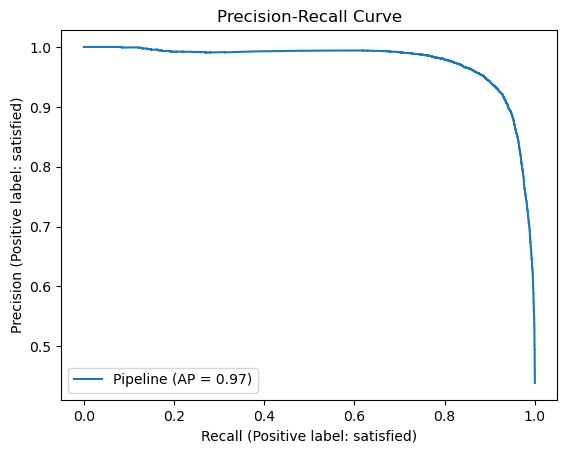

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(
    estimator=final_model,  
    X=X_test,               
    y=y_test,              
    pos_label='satisfied', 
)
plt.title("Precision-Recall Curve")
plt.show()

### ROC Curve
As we know a perfect AUC score is 1.0, our AUC value of 0.98 indicates that the model performs exceptionally well in distinguishing between the positive ("satisfied") and negative ("neutral or dissatisfied") classes.

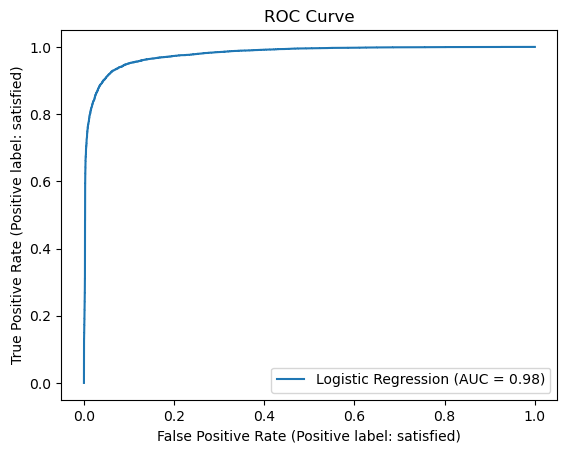

In [34]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
    estimator=final_model,  
    X=X_test,              
    y=y_test,               
    name="Logistic Regression",  
    pos_label="satisfied"       
)
plt.title("ROC Curve")
plt.show()


# Discussion
While the model demonstrates that it is possible to predict customer satisfaction with high accuracy, there are few directions that could be explored to improve it further.  

First, we can compare the 767 false positives and 992 false negatives in the confusion matrix with the correctly classified data. This could help determine which features are causing misclassifications and whether feature engineering can improve the model. Experimenting with various classifiers, such as Random Forest or Gradient Boosting Machines, and making hyperparameter tweaks may also increase performance. For example, improving Logistic Regression regularization or adjusting key parameters in tree-based models may aid in the resolution of misclassifications and improvement of data fit.   

Also, we'd like to determine which specific attributes most strongly drive satisfaction or dissatisfaction. While the existing model is effective at categorization, it does not explain why customers are pleased or unsatisfied. To solve this, we may employ interpretability approaches like SHAP or LIME to determine how particular attributes contribute to model predictions. 

Furthermore, experimental approaches like A/B testing can provide causal insights into how particular variables, such as service quality or flight delays, impact satisfaction.

# References

M. Sadegh Eshaghi, Mona Afshardoost, Gui Lohmann, Brent D Moyle, Drivers and outcomes of airline passenger satisfaction: A Meta-analysis, Journal of the Air Transport Research Society, Volume 3, 2024, 100034, ISSN 2941-198X, https://doi.org/10.1016/j.jatrs.2024.100034.

Namukasa, J. (2013), "The influence of airline service quality on passenger satisfaction and loyalty : The case of Uganda airline industry", The TQM Journal, Vol. 25 No. 5, pp. 520-532. https://doi.org/10.1108/TQM-11-2012-0092

TJ, Klein. (2020, February). "Airline Passenger Satisfaction". Retrieved November 20, 2024 from Kaggle Dataset.

Pedregosa, F. et al., 2011. Scikit-learn: Machine learning in Python. Journal of machine learning research, 12(Oct), pp.2825–2830.

McKinney, Wes. 2010. “Data Structures for Statistical Computing in Python.” In Proceedings of the 9th Python in Science Conference, edited by Stéfan van der Walt and Jarrod Millman, 51–56.